<a href="https://colab.research.google.com/github/pattom72/other/blob/master/liga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy.stats as sts

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [0]:
data= pd.read_csv("/content/liga_hiszpanska.csv")
data.head(3)

,Unnamed: 0,League,Season,Match_id,serie,date,Outcome,home_team_name,guest_team_name,frequency,home_team_position,guest_team_position,home_min_value,home_max_value,home_avg_value,home_median_value,away_min_value,away_max_value,away_avg_value,away_median_value,home_players_avg_age,home_players_median_age,home_players_std_age,home_players_under_21,home_players_above_30,away_players_avg_age,away_players_median_age,away_players_std_age,away_players_under_21,away_players_above_30,home_avg_scored,away_avg_scored,home_avg_lost,away_avg_lost,home_squad_diff,away_squad_diff,home_team_in_europe_last4days,guest_team_in_europe_last4days,guest_team_in_domestic_cup_last4days,home_team_in_domestic_cup_last4days,home_team_last_managerial_change,away_team_last_managerial_change,home_form_quantified_last5_matches,away_form_quantified_last5_matches,home_no_of_wins_in_last5,away_no_of_wins_in_last5,away_no_of_draws_in_last5,home_no_of_draws_in_last5,home_away_history_no_of_won_last5,away_home_history_no_of_won_last5
0,3682,ES1,2005,35966,2,2005-09-10 20:00:00,A,Real Madrid,Celta de Vigo,70000,8,1,2500000,33000000,1.711364e+07,13500000.0,0,7500000,1.909091e+06,1300000.0,27.181818,28.0,3.429816,1,1,26.454545,26.0,2.621589,0,1,2.0,2.0,1.0,0.0,2.0,1.0,0,0,0,0,-1,-1,2.0,2.0,1,1,0,0,1,2
1,3683,ES1,2005,35962,2,2005-09-10 22:00:00,H,Real Betis Balompié,CA Osasuna,40000,11,9,450000,22000000,4.731818e+06,3500000.0,0,3600000,1.072727e+06,600000.0,26.636364,26.0,2.419617,0,1,25.363636,25.0,4.410731,3,2,0.0,2.0,1.0,1.0,2.0,3.0,0,0,0,0,-1,-1,0.0,2.0,0,1,0,0,4,0
2,3684,ES1,2005,35964,2,2005-09-10 22:00:00,H,Deportivo de La Coru?a,Atlético Madrid,24000,2,17,300000,17000000,6.890909e+06,6000000.0,0,25000000,6.590909e+06,6000000.0,29.000000,29.0,3.255764,0,2,24.181818,24.0,2.522625,2,0,1.0,0.0,0.0,0.0,3.0,3.0,0,0,0,0,-1,-1,2.0,1.0,1,0,1,0,3,0


In [0]:
data.dtypes

Unnamed: 0                                int64
League                                   object
Season                                    int64
Match_id                                  int64
serie                                     int64
date                                     object
Outcome                                  object
home_team_name                           object
guest_team_name                          object
frequency                                 int64
home_team_position                        int64
guest_team_position                       int64
home_min_value                            int64
home_max_value                            int64
home_avg_value                          float64
home_median_value                       float64
away_min_value                            int64
away_max_value                            int64
away_avg_value                          float64
away_median_value                       float64
home_players_avg_age                    

In [0]:
X, y = data.drop("Outcome", axis=1), data.Outcome

In [0]:
y

0       A
1       H
2       H
3       H
4       X
       ..
4434    X
4435    H
4436    A
4437    H
4438    A
Name: Outcome, Length: 4439, dtype: object

In [0]:
y.unique()

array(['A', 'H', 'X'], dtype=object)

In [0]:
y = LabelEncoder().fit_transform(y)

In [0]:
y

array([0, 1, 1, ..., 0, 1, 0])

In [0]:
X_enc = pd.get_dummies(X)
X_enc

,Unnamed: 0,Season,Match_id,serie,frequency,home_team_position,guest_team_position,home_min_value,home_max_value,home_avg_value,home_median_value,away_min_value,away_max_value,away_avg_value,away_median_value,home_players_avg_age,home_players_median_age,home_players_std_age,home_players_under_21,home_players_above_30,away_players_avg_age,away_players_median_age,away_players_std_age,away_players_under_21,away_players_above_30,home_avg_scored,away_avg_scored,home_avg_lost,away_avg_lost,home_squad_diff,away_squad_diff,home_team_in_europe_last4days,guest_team_in_europe_last4days,guest_team_in_domestic_cup_last4days,home_team_in_domestic_cup_last4days,home_team_last_managerial_change,away_team_last_managerial_change,home_form_quantified_last5_matches,away_form_quantified_last5_matches,home_no_of_wins_in_last5,...,home_team_name_Villarreal CF,home_team_name_Xerez CD,guest_team_name_Athletic Bilbao,guest_team_name_Atlético Madrid,guest_team_name_CA Osasuna,guest_team_name_CD Leganés,guest_team_name_CD Numancia,guest_team_name_CD Tenerife,guest_team_name_Celta de Vigo,guest_team_name_Cádiz CF,guest_team_name_Córdoba CF,guest_team_name_Deportivo Alavés,guest_team_name_Deportivo de La Coru?a,guest_team_name_Elche CF,guest_team_name_FC Barcelona,guest_team_name_Getafe CF,guest_team_name_Gimn?stic de Tarragona,guest_team_name_Granada CF,guest_team_name_Hércules CF,guest_team_name_Levante UD,guest_team_name_Málaga CF,guest_team_name_RCD Espanyol Barcelona,guest_team_name_RCD Mallorca,guest_team_name_Racing Santander,guest_team_name_Rayo Vallecano,guest_team_name_Real Betis Balompié,guest_team_name_Real Madrid,guest_team_name_Real Murcia CF,guest_team_name_Real Sociedad,guest_team_name_Real Valladolid CF,guest_team_name_Real Zaragoza,guest_team_name_Recreativo Huelva,guest_team_name_SD Eibar,guest_team_name_Sevilla FC,guest_team_name_Sporting Gijón,guest_team_name_UD Almería,guest_team_name_UD Las Palmas,guest_team_name_Valencia CF,guest_team_name_Villarreal CF,guest_team_name_Xerez CD
0,3682,2005,35966,2,70000,8,1,2500000,33000000,1.711364e+07,13500000.0,0,7500000,1.909091e+06,1300000.0,27.181818,28.0,3.429816,1,1,26.454545,26.0,2.621589,0,1,2.0,2.0,1.0,0.0,2.0,1.0,0,0,0,0,-1,-1,2.0,2.0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3683,2005,35962,2,40000,11,9,450000,22000000,4.731818e+06,3500000.0,0,3600000,1.072727e+06,600000.0,26.636364,26.0,2.419617,0,1,25.363636,25.0,4.410731,3,2,0.0,2.0,1.0,1.0,2.0,3.0,0,0,0,0,-1,-1,0.0,2.0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3684,2005,35964,2,24000,2,17,300000,17000000,6.890909e+06,6000000.0,0,25000000,6.590909e+06,6000000.0,29.000000,29.0,3.255764,0,2,24.181818,24.0,2.522625,2,0,1.0,0.0,0.0,0.0,3.0,3.0,0,0,0,0,-1,-1,2.0,1.0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3685,2005,35968,2,20370,13,16,0,6000000,2.095455e+06,2000000.0,0,3000000,5.863636e+05,300000.0,26.545455,26.0,3.503245,1,2,27.636364,27.0,3.042128,0,2,0.0,0.0,3.0,0.0,2.0,0.0,0,0,0,0,-1,24,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3686,2005,35963,2,13000,4,3,120000,4000000,1.154091e+06,500000.0,0,7500000,2.495455e+06,900000.0,27.000000,28.0,3.255764,1,1,24.272727,25.0,2.327699,2,0,2.0,3.0,0.0,0.0,0.0,0.0,0,0,0,0,-1,-1,2.0,2.0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4434,8227,2016,2719087,38,14188,13,6,2500000,16000000,6.272727e+06,6000000.0,1000000,15000000,8.090909e+06,10000000.0,27.636364,29.0,3.107176,0,1,25.909091,26.0,3.780332,2,1,0.6,1.8,3.0,1.2,2.0,3.0,0,0,0,0,3695,4077,0.0

In [0]:
scaler = StandardScaler()
X_enc[['frequency', 'home_min_value','home_max_value','home_avg_value']] = scaler.fit_transform(X_enc[['frequency', 'home_min_value','home_max_value','home_avg_value']])

In [0]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=123) 

In [0]:
X_train_val.head(3)

,Unnamed: 0,Season,Match_id,serie,frequency,home_team_position,guest_team_position,home_min_value,home_max_value,home_avg_value,home_median_value,away_min_value,away_max_value,away_avg_value,away_median_value,home_players_avg_age,home_players_median_age,home_players_std_age,home_players_under_21,home_players_above_30,away_players_avg_age,away_players_median_age,away_players_std_age,away_players_under_21,away_players_above_30,home_avg_scored,away_avg_scored,home_avg_lost,away_avg_lost,home_squad_diff,away_squad_diff,home_team_in_europe_last4days,guest_team_in_europe_last4days,guest_team_in_domestic_cup_last4days,home_team_in_domestic_cup_last4days,home_team_last_managerial_change,away_team_last_managerial_change,home_form_quantified_last5_matches,away_form_quantified_last5_matches,home_no_of_wins_in_last5,...,home_team_name_Villarreal CF,home_team_name_Xerez CD,guest_team_name_Athletic Bilbao,guest_team_name_Atlético Madrid,guest_team_name_CA Osasuna,guest_team_name_CD Leganés,guest_team_name_CD Numancia,guest_team_name_CD Tenerife,guest_team_name_Celta de Vigo,guest_team_name_Cádiz CF,guest_team_name_Córdoba CF,guest_team_name_Deportivo Alavés,guest_team_name_Deportivo de La Coru?a,guest_team_name_Elche CF,guest_team_name_FC Barcelona,guest_team_name_Getafe CF,guest_team_name_Gimn?stic de Tarragona,guest_team_name_Granada CF,guest_team_name_Hércules CF,guest_team_name_Levante UD,guest_team_name_Málaga CF,guest_team_name_RCD Espanyol Barcelona,guest_team_name_RCD Mallorca,guest_team_name_Racing Santander,guest_team_name_Rayo Vallecano,guest_team_name_Real Betis Balompié,guest_team_name_Real Madrid,guest_team_name_Real Murcia CF,guest_team_name_Real Sociedad,guest_team_name_Real Valladolid CF,guest_team_name_Real Zaragoza,guest_team_name_Recreativo Huelva,guest_team_name_SD Eibar,guest_team_name_Sevilla FC,guest_team_name_Sporting Gijón,guest_team_name_UD Almería,guest_team_name_UD Las Palmas,guest_team_name_Valencia CF,guest_team_name_Villarreal CF,guest_team_name_Xerez CD
1800,5522,2009,957653,34,2.880984,1,20,0.650890,1.880741,1.577514,16000000.0,800000,3000000,1.618182e+06,1600000.0,28.181818,28.0,3.370999,0,3,25.272727,25.0,2.533413,0,1,2.0,1.8,0.2,1.2,6.0,3.0,0,0,0,0,663,96,1.8,1.2,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1845,5567,2009,957691,38,3.714138,1,18,3.712831,2.480144,2.043247,20000000.0,0,5000000,2.000000e+06,1800000.0,25.545455,27.0,4.321195,2,1,25.545455,26.0,3.670521,1,2,2.8,1.0,1.0,0.8,2.0,2.0,0,0,0,0,685,40,1.8,1.2,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4109,7902,2016,2718762,6,0.459521,10,17,-0.486402,-0.476913,-0.469688,3000000.0,2000000,10000000,4.136364e+06,3500000.0,26.272727,25.0,5.061441,1,2,26.181818,26.0,4.166970,2,2,1.4,1.0,2.2,1.4,2.0,3.0,0,0,0,0,3767,3738,0.8,0.8,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X_test.head(3)

,Unnamed: 0,Season,Match_id,serie,frequency,home_team_position,guest_team_position,home_min_value,home_max_value,home_avg_value,home_median_value,away_min_value,away_max_value,away_avg_value,away_median_value,home_players_avg_age,home_players_median_age,home_players_std_age,home_players_under_21,home_players_above_30,away_players_avg_age,away_players_median_age,away_players_std_age,away_players_under_21,away_players_above_30,home_avg_scored,away_avg_scored,home_avg_lost,away_avg_lost,home_squad_diff,away_squad_diff,home_team_in_europe_last4days,guest_team_in_europe_last4days,guest_team_in_domestic_cup_last4days,home_team_in_domestic_cup_last4days,home_team_last_managerial_change,away_team_last_managerial_change,home_form_quantified_last5_matches,away_form_quantified_last5_matches,home_no_of_wins_in_last5,...,home_team_name_Villarreal CF,home_team_name_Xerez CD,guest_team_name_Athletic Bilbao,guest_team_name_Atlético Madrid,guest_team_name_CA Osasuna,guest_team_name_CD Leganés,guest_team_name_CD Numancia,guest_team_name_CD Tenerife,guest_team_name_Celta de Vigo,guest_team_name_Cádiz CF,guest_team_name_Córdoba CF,guest_team_name_Deportivo Alavés,guest_team_name_Deportivo de La Coru?a,guest_team_name_Elche CF,guest_team_name_FC Barcelona,guest_team_name_Getafe CF,guest_team_name_Gimn?stic de Tarragona,guest_team_name_Granada CF,guest_team_name_Hércules CF,guest_team_name_Levante UD,guest_team_name_Málaga CF,guest_team_name_RCD Espanyol Barcelona,guest_team_name_RCD Mallorca,guest_team_name_Racing Santander,guest_team_name_Rayo Vallecano,guest_team_name_Real Betis Balompié,guest_team_name_Real Madrid,guest_team_name_Real Murcia CF,guest_team_name_Real Sociedad,guest_team_name_Real Valladolid CF,guest_team_name_Real Zaragoza,guest_team_name_Recreativo Huelva,guest_team_name_SD Eibar,guest_team_name_Sevilla FC,guest_team_name_Sporting Gijón,guest_team_name_UD Almería,guest_team_name_UD Las Palmas,guest_team_name_Valencia CF,guest_team_name_Villarreal CF,guest_team_name_Xerez CD
4411,8204,2016,2719060,36,0.977210,3,8,1.307020,2.480144,2.757033,35000000.0,1000000,7500000,2.836364e+06,2500000.0,26.181818,25.0,4.142902,1,3,27.181818,27.0,2.638870,0,1,2.0,0.8,0.4,0.6,3.0,3.0,0,0,0,0,4012,676,1.4,1.0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4419,8212,2016,2719074,37,-0.442943,10,12,-0.223950,-0.456932,-0.361354,3500000.0,2500000,18000000,1.022727e+07,10000000.0,26.909091,27.0,4.700097,2,2,26.545455,26.0,3.045115,1,1,0.8,1.4,1.2,1.6,2.0,3.0,0,0,0,0,4005,3280,1.0,0.6,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3141,6904,2013,2341047,20,-0.475518,15,19,-0.617628,-0.536853,-0.563847,1500000.0,800000,5000000,2.236364e+06,2000000.0,26.545455,25.0,4.524680,1,3,25.363636,24.0,3.801913,2,1,0.4,1.2,2.0,2.2,2.0,0.0,0,0,1,0,-1,575,0.2,0.6,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
algorithms = {
    'knn': KNeighborsClassifier(),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier()
}

In [0]:
kfold = KFold(n_splits=15, random_state=456)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [0]:
tree_params_grid = {
    'max_depth': [3, 5, 10, 20],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 5, 10, 20]
}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params_grid, cv=kfold, n_jobs=3)
grid_tree_results = grid_tree.fit(X_train_val, y_train_val)

In [0]:
grid_tree_results.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
algorithms['dt'] = grid_tree_results.best_estimator_

In [0]:
results = {}
for algo_name, algo in algorithms.items():
    algo_results = cross_val_score(algo, X_train_val, y_train_val, cv=kfold, n_jobs=4)
    results['model_' + algo_name] = algo_results

In [0]:
results_df = pd.DataFrame.from_dict(results)

In [0]:
results_df.mean(axis=0)

model_knn    0.492857
model_dt     0.567174
model_rf     0.559868
dtype: float64

In [0]:
results_df.std(axis=0)

model_knn    0.043527
model_dt     0.031343
model_rf     0.041087
dtype: float64

In [0]:
results_df

,model_knn,model_dt,model_rf
0,0.459916,0.561181,0.527426
1,0.485232,0.586498,0.578059
2,0.502110,0.578059,0.599156
3,0.523207,0.578059,0.552743
4,0.468354,0.590717,0.573840
5,0.400844,0.481013,0.459916
6,0.485232,0.565401,0.523207
7,0.464135,0.544304,0.523207
8,0.472574,0.544304,0.556962
9,0.531646,0.556962,0.565401


In [0]:
sts.friedmanchisquare(results_df.model_knn, results_df.model_rf, results_df.model_dt)

FriedmanchisquareResult(statistic=19.73333333333332, pvalue=5.1875358599977194e-05)

In [0]:
from statsmodels.sandbox.stats.multicomp import MultiComparison

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
results_df2 = results_df.copy()
results_df2['id'] = results_df2.index
results_reformatted = pd.melt(results_df2, id_vars='id').drop('id', axis=1)

In [0]:
results_reformatted

,variable,value
0,model_knn,0.459916
1,model_knn,0.485232
2,model_knn,0.502110
3,model_knn,0.523207
4,model_knn,0.468354
5,model_knn,0.400844
6,model_knn,0.485232
7,model_knn,0.464135
8,model_knn,0.472574
9,model_knn,0.531646


In [0]:
multicomp = MultiComparison(
    data=results_reformatted.value,
    groups=results_reformatted.variable,
)
print(multicomp.tukeyhsd())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
 model_dt model_knn  -0.0743  0.001 -0.1089 -0.0397   True
 model_dt  model_rf  -0.0073 0.8538 -0.0419  0.0273  False
model_knn  model_rf    0.067  0.001  0.0324  0.1016   True
----------------------------------------------------------


In [0]:
!pip install scikit-posthocs

  Using cached https://files.pythonhosted.org/packages/3b/b8/8a9769c7a286070f74fbc56bcede507680210010ce0887c70112e70ced5a/scikit_posthocs-0.6.4-py3-none-any.whl


In [0]:
import scikit_posthocs as sp

In [0]:
pvals = sp.posthoc_tukey(results_reformatted, val_col='value', group_col='variable', )
pvals < 0.05

,model_knn,model_dt,model_rf
model_knn,True,True,True
model_dt,True,True,False
model_rf,True,False,True


In [0]:
pvals

,model_knn,model_dt,model_rf
model_knn,-1.000,0.001000,0.001000
model_dt,0.001,-1.000000,0.853764
model_rf,0.001,0.853764,-1.000000


In [0]:
import xgboost as xgb

In [0]:
xgb_clas = xgb.XGBClassifier(max_depth=5, learning_rate=0.01)
scores = cross_val_score(xgb_clas, X_train_val, y_train_val, cv=10)
scores

array([0.59831461, 0.57464789, 0.5943662 , 0.56338028, 0.55774648,
       0.57746479, 0.54929577, 0.6       , 0.57183099, 0.6056338 ])

In [0]:
xgb_clas.fit(X_train_val,y_train_val)
preds = xgb_clas.predict(X_test)
preds

array([1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2,
       1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1,
       0, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [0]:
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print()
print(classification_report(y_true, y_pred))

Accuracy: 0.5765765765765766

              precision    recall  f1-score   support

           0       0.52      0.56      0.54       243
           1       0.62      0.83      0.71       429
           2       0.38      0.08      0.14       216

    accuracy                           0.58       888
   macro avg       0.50      0.49      0.46       888
weighted avg       0.53      0.58      0.52       888



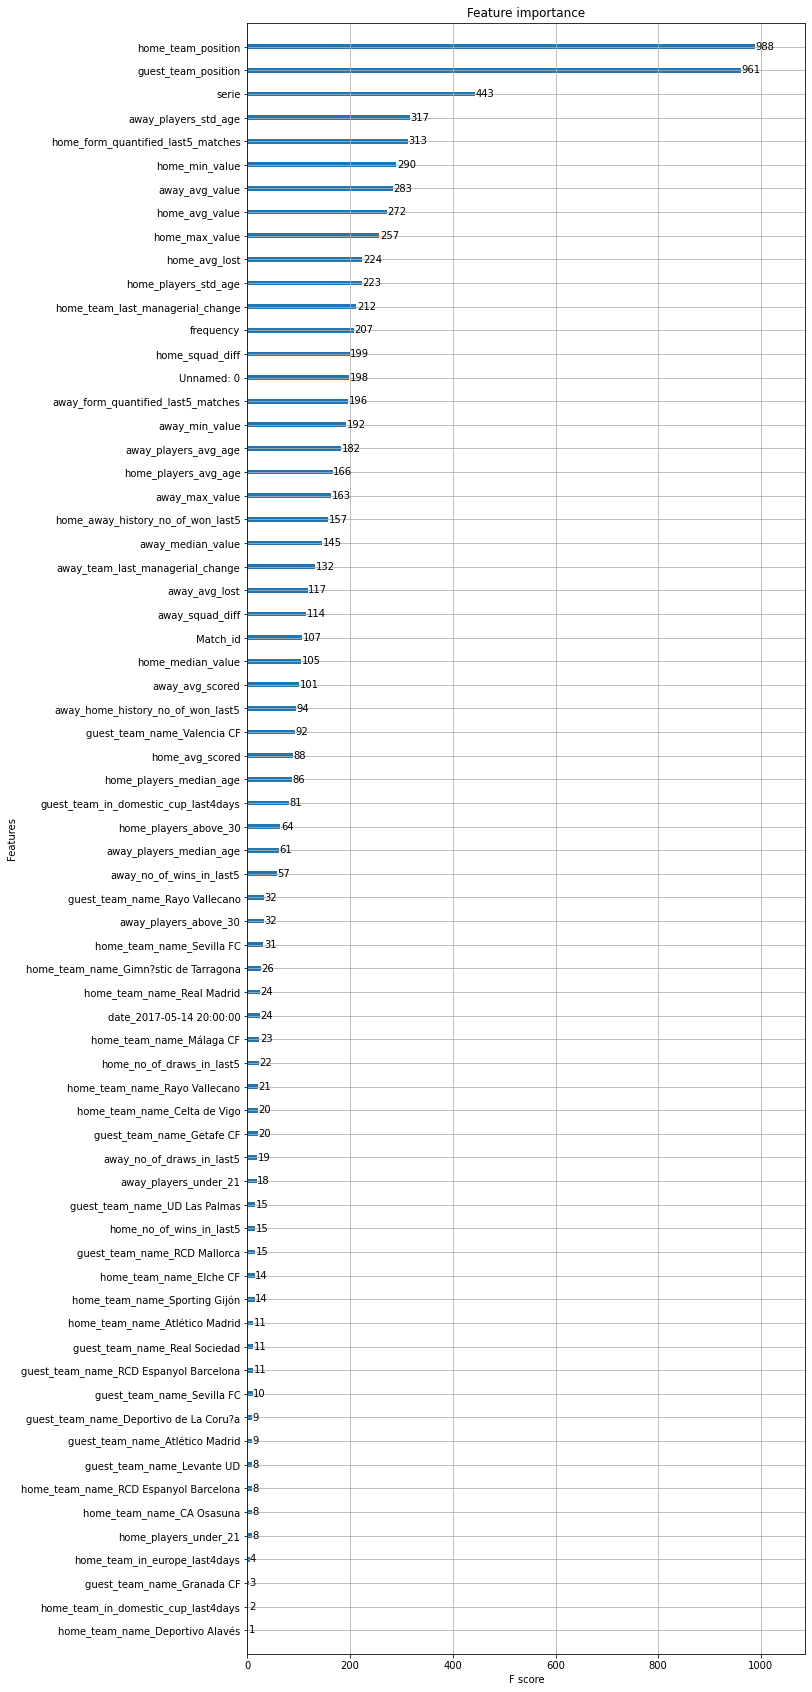

In [0]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_clas)
plt.rcParams['figure.figsize'] = [40, 30]
plt.show()

In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 11.0MB/s 


In [0]:
import eli5 
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
imp = PermutationImportance(xgb_clas, random_state=0).fit(X_train_val,y_train_val)
eli5.show_weights(imp)

Weight,Feature
0.1441 ± 0.0069,x5
0.1308 ± 0.0055,x6
0.0208 ± 0.0046,x37
0.0124 ± 0.0039,x38
0.0114 ± 0.0069,x3
0.0084 ± 0.0017,x27
0.0078 ± 0.0028,x8
0.0067 ± 0.0038,x13
0.0060 ± 0.0016,x22
0.0050 ± 0.0024,x4
